In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
from tqdm import tqdm 

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier   # FFNN
from sklearn.metrics import accuracy_score         # accuracy for ffnn
fraction = [i / 20 for i in range(1, 20)]          # fraction of training set

mycmap = "spring"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13

plt.style.use(["science", "grid", "notebook"])

In [2]:
dname="./DATA/"
str0="_XGB_25.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

def split_dataset(i):
    f = fraction[i]
    N_train = int(f * N) #75% training -> 25% test
    x_train,y_train = x[:N_train],y[:N_train]
    x_test,y_test   = x[N_train:],y[N_train:]
    return x_train,y_train,x_test,y_test
#####

x_train, y_train, x_test, y_test = split_dataset(14)

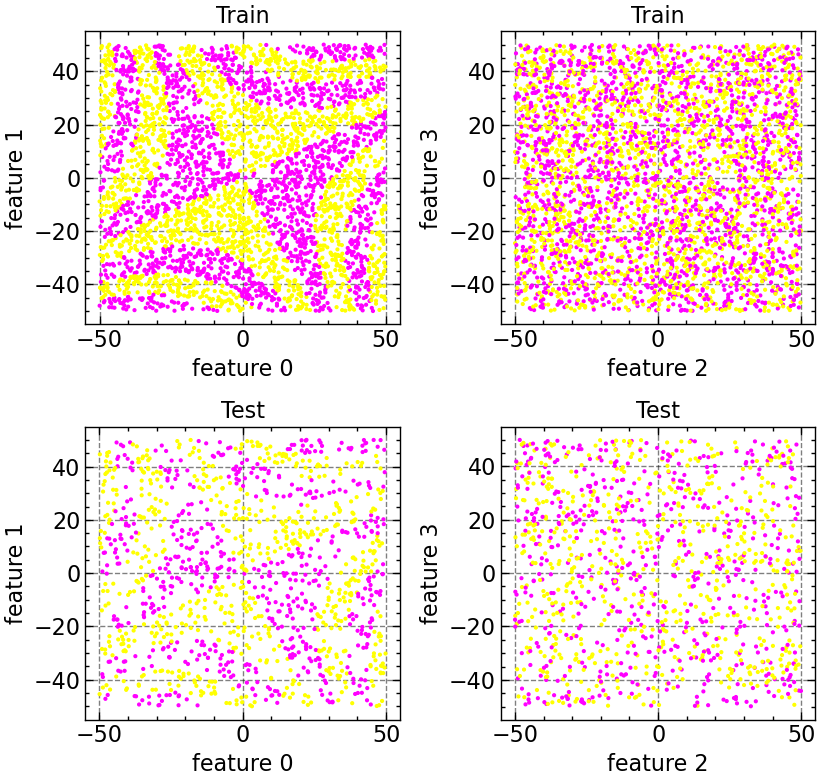

In [3]:
#original dataset visualization
def scatt(ax, x, y, i=0, j=1, s=4, title=""):
    ax.scatter(x[:,i], x[:,j], s=s, c=y)
    ax.set_xlabel(f'feature {i}')
    ax.set_ylabel(f'feature {j}')
    ax.set_title(title)

fig,ax=plt.subplots(2,2, figsize=(8.5,8.1))
scatt(ax[0,0], x_train, y_train, title='Train')
scatt(ax[0,1], x_train, y_train, i=2, j=3, title='Train')
scatt(ax[1,0], x_test, y_test, title='Test')
scatt(ax[1,1], x_test, y_test, i=2, j=3, title='Test')
plt.tight_layout()
plt.show()

errors: 6.64    accuracy=0.934


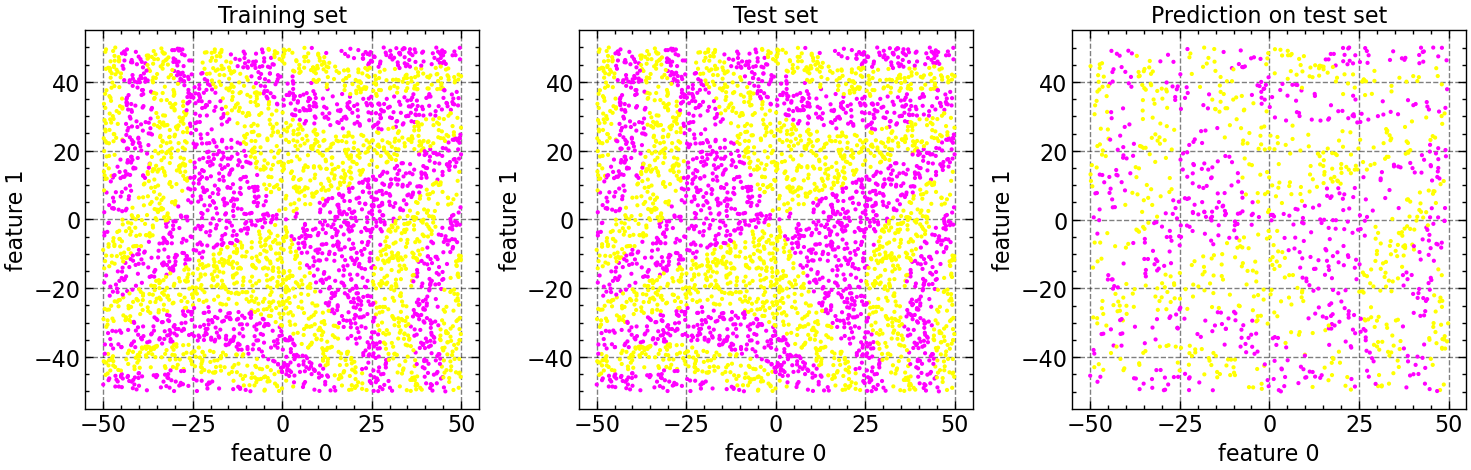

In [4]:
model = XGBClassifier(objective='binary:logistic', importance_type='gain')
#xgboost con diversi parametri
model.fit(x_train, y_train)
y_test_hat=model.predict(x_test)
print("errors: {:.2f}    accuracy={:.3f}".format(100*(1-model.score(x_test, y_test)), model.score(x_test, y_test)))

fig, ax = plt.subplots(1,3,figsize=(15,5))
scatt(ax[0], x_train, y_train, title='Training set')
scatt(ax[1], x_train, y_train, title='Test set')
scatt(ax[2], x_test, y_test_hat, title='Prediction on test set')
fig.tight_layout()
plt.show()

### FFNN

In [6]:
def cross_validation(mlp, x_train, y_train, x_test, y_test):
    xsets = np.array(x_train)
    ysets = np.array(y_train)
    accuracies = []
    #
    for i in range(1, 11):
        x = xsets[(np.arange(len(xsets)) % 10) != i]
        y = ysets[(np.arange(len(xsets)) % 10) != i]
        mlp.fit(x, y)
        y_pred = mlp.predict(x_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    #####
    #
    accuracies = np.array(accuracies)
    return accuracies.mean(), accuracies.std()
#####

MLP_accuracies = []
for i in tqdm(range(len(fraction))):
    mlp = MLPClassifier(hidden_layer_sizes = (10, 10),  # Two hidden layers with 10 neurons each
                        max_iter           = 1000,      # Maximum number of iterations
                        random_state       = 42)
    #####################
    #
    x_train, y_train, x_test, y_test       = split_dataset(i)
    MLP_accuracies.append(cross_validation(mlp, x_train, y_train, x_test, y_test))
#####
MLP_accuracies = np.array(MLP_accuracies)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [02:49<00:00,  8.90s/it]


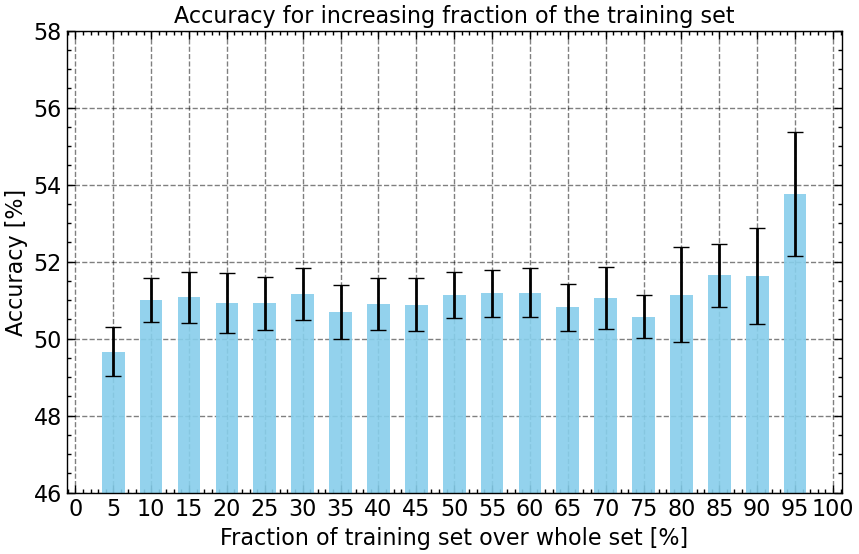

In [29]:
# Creazione del grafico con barre di errore
plt.figure(figsize = (10, 6))
plt.bar(np.array(fraction) * 100,
        MLP_accuracies[:,0] * 100,
        yerr = MLP_accuracies[:,1] * 100,
        width = 3,
        capsize = 6,
        color = 'skyblue',
        alpha = 0.9)
#plt.errorbar(np.array(fraction) * 100, accuracies[:,0], yerr = accuracies[:,1], fmt = 'o', capsize = 5, label='Dati con errore')

# Aggiunta di etichette e titolo
plt.xlabel('Fraction of training set over whole set [%]')
plt.xticks(np.arange(0, 101, 5))
plt.ylabel('Accuracy [%]')
plt.ylim(46, 58)
plt.title('Accuracy for increasing fraction of the training set')
#plt.legend()

# Mostra il grafico
plt.grid(True)
plt.show()

In [8]:
def cross_validation(mlp, x_train, y_train, x_test, y_test):
    xsets = np.array(x_train)
    ysets = np.array(y_train)
    accuracies = []
    #
    for i in range(1, 11):
        x = xsets[(np.arange(len(xsets)) % 10) != i]
        y = ysets[(np.arange(len(xsets)) % 10) != i]
        mlp.fit(x, y)
        y_pred = mlp.predict(x_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    #####
    #
    accuracies = np.array(accuracies)
    return accuracies.mean(), accuracies.std()
#####

XGB_accuracies = []
for i in tqdm(range(len(fraction))):
    mlp = XGBClassifier(objective       = 'binary:logistic',
                        importance_type = 'gain')
    #####################
    #
    x_train, y_train, x_test, y_test       = split_dataset(i)
    XGB_accuracies.append(cross_validation(mlp, x_train, y_train, x_test, y_test))
#####
XGB_accuracies = np.array(XGB_accuracies)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:17<00:00,  1.08it/s]


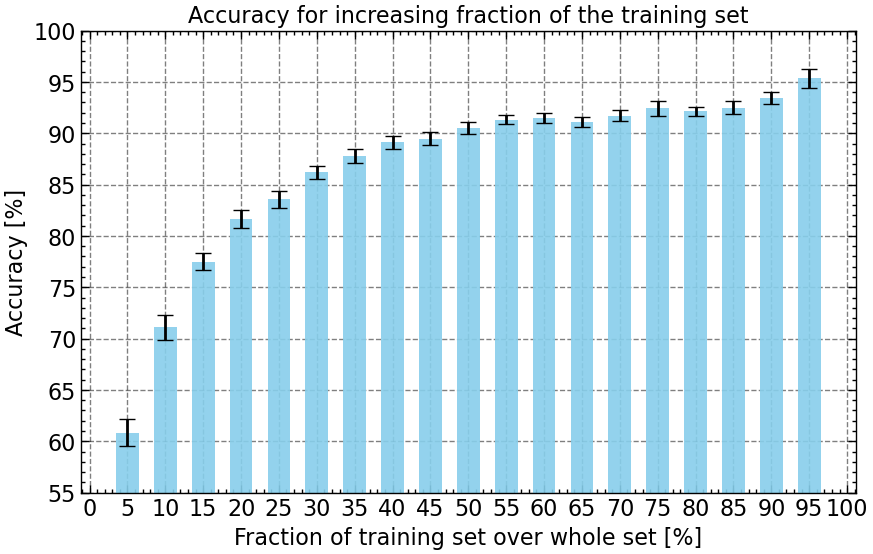

In [33]:
# Creazione del grafico con barre di errore
plt.figure(figsize = (10, 6))
plt.bar(np.array(fraction) * 100,
        XGB_accuracies[:,0] * 100,
        yerr = XGB_accuracies[:,1] * 100,
        width = 3,
        capsize = 6,
        color = 'skyblue',
        alpha = 0.9)
#plt.errorbar(np.array(fraction) * 100, accuracies[:,0], yerr = accuracies[:,1], fmt = 'o', capsize = 5, label='Dati con errore')

# Aggiunta di etichette e titolo
plt.xlabel('Fraction of training set over whole set [%]')
plt.xticks(np.arange(0, 101, 5))
plt.ylabel('Accuracy [%]')
plt.ylim(55, 100)
plt.title('Accuracy for increasing fraction of the training set')
#plt.legend()

# Mostra il grafico
plt.grid(True)
plt.show()